# Машинное обучение, ФКН ВШЭ

## Практическое задание 7. Градиентный бустинг ~~своими руками~~

### Общая информация
Дата выдачи: 04.12.2019

Мягкий дедлайн: 05:59MSK 15.12.2019

Жесткий дедлайн: 05:59MSK 17.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 15.5 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

In [164]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc, precision_recall_curve
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import average_precision_score
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

__Задание 1. (0.5 балла)__

Мы будем использовать данные из [соревнования](https://www.kaggle.com/t/b710e05dc0bd424995ca94da5b639869). 
* Загрузите таблицу application_train.csv;
* Запишите в Y столбец с целевой переменной (TARGET);
* Удалите ненужные столбцы (для этого воспользуйтесь описанием);
* Определите тип столбцов и заполните пропуски - стратегия произвольная;
* Разбейте выборку в соотношении 70:30 с random_state=0.

Так как в данных имеется значительный дисбаланс классов, в качестве метрики качества везде будем использовать площадь под precision-recall кривой (AUC-PR).

In [2]:
data = pd.read_csv('application_train.csv')
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,247330,0,Cash loans,F,N,N,0,157500.0,706410.0,67072.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,425716,1,Cash loans,F,Y,Y,1,121500.0,545040.0,25407.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,331625,0,Cash loans,M,Y,Y,1,225000.0,942300.0,27679.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,455397,0,Revolving loans,F,N,Y,2,144000.0,180000.0,9000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
4,449114,0,Cash loans,F,N,Y,0,112500.0,729792.0,37390.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0


In [3]:
y = data['TARGET']
X = data.drop(['TARGET', 'SK_ID_CURR'], axis=1)

In [4]:
categorical = list(X.dtypes[X.dtypes == 'object'].index)
X[categorical] = X[categorical].fillna("NotGiven")

numerical = list(X.dtypes[X.dtypes != 'object'].index)

In [6]:
X[numerical].isna().any()

CNT_CHILDREN                  False
AMT_INCOME_TOTAL              False
AMT_CREDIT                    False
AMT_ANNUITY                    True
AMT_GOODS_PRICE                True
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY      True
AMT_REQ_CREDIT_BUREAU_WEEK     True
AMT_REQ_CREDIT_BUREAU_MON      True
AMT_REQ_CREDIT_BUREAU_QRT      True
AMT_REQ_CREDIT_BUREAU_YEAR     True
Length: 104, dtype: bool

In [7]:
X = X.fillna(X[numerical].mean())

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

__Задание 2. (1.5 балла)__

Обучите реализации градиентного бустинга LightGBM и Catboost на вещественных признаках без подбора параметров. 
Почему получилась заметная разница в качестве? 

В этом и последующих экспериментах необходимо измерять время обучения моделей.

In [97]:
%%time
clf0 = LGBMClassifier(silent=True)
clf0.fit(X_train[numerical], y_train)

CPU times: user 19.9 s, sys: 1.36 s, total: 21.3 s
Wall time: 6.97 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [98]:
print(average_precision_score(y_test, clf0.predict_proba(X_test[numerical])[:, 1]))

0.23914611722405615


In [95]:
%%time
clf = CatBoostClassifier(silent=True)
clf.fit(X_train[numerical], y_train)

CPU times: user 3min 55s, sys: 6.45 s, total: 4min 1s
Wall time: 1min 2s


In [96]:
print(average_precision_score(y_test, clf.predict_proba(X_test[numerical])[:, 1]))

0.23782651036315233


Качество отличается несильно. LGBM справился чуть лучше

__Задание 3. (2 балла)__

Подберите оптимальные с точки зрения метрики качества параметры алгоритмов, изменяя:

* глубину деревьев;
* количество деревьев;
* темп обучения.

Масштаб значений предлагается посмотреть в семинаре про библиотеки.

Проанализируйте соотношения глубины и количества деревьев в зависимости от алгоритма. 

In [138]:
cat_params = {
    "max_depth": [3, 5, 7],
    "learning_rate" : [0.01, 0.1],
    "n_estimators":  [1, 100, 300, 500]
}
lgbm_params = {
    "max_depth": [1, 5, 10, 15],
    "learning_rate" : [0.01, 0.1],
    "n_estimators":  [1, 100, 300, 500]
}
scorer = make_scorer(average_precision_score, needs_proba=True)

In [139]:
cat_gs = GridSearchCV(CatBoostClassifier(silent=True), param_grid=cat_params, scoring=scorer)
lgbm_gs = GridSearchCV(LGBMClassifier(silent=True), param_grid=lgbm_params, scoring=scorer)

In [141]:
%%time
lgbm_gs.fit(X_train[numerical], y_train)

/home/dilara/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 50min 34s, sys: 15.4 s, total: 50min 50s
Wall time: 15min 46s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.1],
                        

In [142]:
lgbm_gs.best_score_

0.22723297897195238

In [143]:
lgbm_gs.best_estimator_.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.01,
 'max_depth': 15,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 500,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [144]:
%%time
cat_gs.fit(X_train[numerical], y_train)

/home/dilara/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CPU times: user 47min 46s, sys: 2min 7s, total: 49min 54s
Wall time: 15min 50s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x7f56d5d0cdd0>,
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 5, 7],
                         'n_estimators': [1, 100, 300, 500]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(average_precision_score, needs_proba=True),
             verbose=0)

In [145]:
cat_gs.best_score_

0.23259182329946498

In [147]:
cat_gs.best_estimator_.get_params()

{'silent': True, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}

In [148]:
lgbm_params

{'max_depth': [1, 5, 10, 15],
 'learning_rate': [0.01, 0.1],
 'n_estimators': [1, 100, 300, 500]}

__Задание 4. (3.5 балла)__

Добавьте категориальные признаки к вещественным следующими способами:

* как OHE признаки;
* как счетчики со сглаживанием.

При подсчете счетчиков запрещается использование циклов. 

Как меняется время, необходимое для обучения моделей в зависимости от способа кодирования? Сравните полученные результаты с встроенными методами обработки категориальных признаков. 

In [65]:
def onehot(df, categorical):
    X = df.copy()
    for f_j in categorical:
        df = pd.concat([df,
                        pd.get_dummies(X[f_j], prefix=f_j)
                       ], axis=1)
    return df

In [66]:
X2 = onehot(X, categorical).drop(categorical, axis=1)

In [69]:
x_train0, x_test0, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=0)

In [70]:
%%time
clf_cat0 = CatBoostClassifier(silent=True, learning_rate=0.1, max_depth = 3, n_estimators = 500)
clf_cat0.fit(x_train0, y_train)

CPU times: user 1min 34s, sys: 3.05 s, total: 1min 37s
Wall time: 27 s


In [71]:
print(average_precision_score(y_test, clf_cat0.predict_proba(x_test0)[:, 1]))

0.24832033798884756


Стало лучше!

In [72]:
%%time
clf_lgbm_0 = LGBMClassifier(silent=True, learning_rate=0.1, max_depth = 3, n_estimators = 300)
clf_lgbm_0.fit(x_train0, y_train)

CPU times: user 31.7 s, sys: 232 ms, total: 31.9 s
Wall time: 9.41 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=3,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [73]:
print(average_precision_score(y_test, clf_lgbm_0.predict_proba(x_test0)[:, 1]))

0.2476545823730444


Счетчики

In [74]:
x_train, x_test = X_train.copy(), X_test.copy()
x_train['y'], x_test['y'] = y_train, y_test

In [75]:
def calc_smooth_mean(data, cat, target, C):
    global_mean = data[target].mean()

    agg = data.groupby(cat)[target].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    smooth = (counts * means + C * global_mean) / (counts + C)

    return data[cat].map(smooth)

In [76]:
for f_j in categorical:
    x_train[f_j] = calc_smooth_mean(x_train, f_j, 'y', 10)
    x_test[f_j] = calc_smooth_mean(x_test, f_j, 'y', 10)
x_train.drop(['y'], axis=1, inplace=True)
x_test.drop(['y'], axis=1, inplace=True)

In [77]:
x_train1, x_test1 = x_train.copy(), x_test.copy()

In [78]:
%%time
clf_cat_1 = CatBoostClassifier(silent=True, learning_rate=0.1, max_depth = 3, n_estimators = 500)
clf_cat_1.fit(x_train1, y_train)

CPU times: user 1min 35s, sys: 3.26 s, total: 1min 38s
Wall time: 28.8 s


In [79]:
print(average_precision_score(y_test, clf_cat_1.predict_proba(x_test1)[:, 1]))

0.2500493349057568


Ещё лучше

In [80]:
%%time
clf_lgbm_1 = LGBMClassifier(silent=True, learning_rate=0.1, max_depth = 3, n_estimators = 300)
clf_lgbm_1.fit(x_train1, y_train)

CPU times: user 29.4 s, sys: 140 ms, total: 29.5 s
Wall time: 8.05 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=3,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [81]:
print(average_precision_score(y_test, clf_lgbm_1.predict_proba(x_test1)[:, 1]))

0.24744201396372595


In [82]:
x = X.copy()
for c in x.columns:
    col_type = x[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        x[c] = x[c].astype('category')

In [83]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215257 entries, 0 to 215256
Columns: 120 entries, NAME_CONTRACT_TYPE to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: category(16), float64(65), int64(39)
memory usage: 174.1 MB


In [84]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [18]:
%%time
clf_lgbm_2 = LGBMClassifier(silent=True, learning_rate=0.1, max_depth = 3, n_estimators = 300)
clf_lgbm_2.fit(x_train, y_train)

CPU times: user 32.5 s, sys: 116 ms, total: 32.6 s
Wall time: 9.13 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=3,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [19]:
print(average_precision_score(y_test, clf_lgbm_2.predict_proba(x_test)[:, 1]))

0.24678388027346126


In [20]:
%%time
clf_cat_2 = CatBoostClassifier(silent=True, learning_rate=0.1, max_depth = 3, n_estimators = 500, cat_features = categorical)
clf_cat_2.fit(x_train, y_train)

CPU times: user 4min 57s, sys: 10.3 s, total: 5min 7s
Wall time: 1min 29s


In [21]:
print(average_precision_score(y_test, clf_cat_2.predict_proba(x_test)[:, 1]))

0.24965877371845188


__Задание 5. (1 балл)__

Реализуйте блендинг подобранных в предыдущем задании моделей и сравните качество. Обратите внимание на данные, на которых обучаются 

In [87]:
y_pred_lgbm_0 = clf_lgbm_0.predict_proba(x_test0)[:, 1]
y_pred_cat_0 = clf_cat0.predict_proba(x_test0)[:, 1]

y_pred_lgbm_0_train = clf_lgbm_0.predict_proba(x_train0)[:, 1]
y_pred_cat_0_train = clf_cat0.predict_proba(x_train0)[:, 1]

y_pred_lgbm_1 = clf_lgbm_1.predict_proba(x_test1)[:, 1]
y_pred_cat_1 = clf_cat_1.predict_proba(x_test1)[:, 1]

y_pred_lgbm_1_train = clf_lgbm_1.predict_proba(x_train1)[:, 1]
y_pred_cat_1_train = clf_cat_1.predict_proba(x_train1)[:, 1]

y_pred_lgbm_2 = clf_lgbm_2.predict_proba(x_test)[:, 1]
y_pred_cat_2 = clf_cat_2.predict_proba(x_test)[:, 1]

y_pred_lgbm_2_train = clf_lgbm_2.predict_proba(x_train)[:, 1]
y_pred_cat_2_train = clf_cat_2.predict_proba(x_train)[:, 1]

In [123]:
train_stack = np.vstack((y_pred_lgbm_0_train, y_pred_cat_0_train, y_pred_lgbm_1_train, y_pred_cat_1_train, y_pred_lgbm_2_train, y_pred_cat_2_train)).T

In [124]:
train_stack.shape

(150679, 6)

In [134]:
%%time
lr = LogisticRegression()
lr.fit(train_stack, y_train)

/home/dilara/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 384 ms, sys: 4 ms, total: 388 ms
Wall time: 386 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [137]:
average_precision_score(y_train, lr.predict_proba(train_stack)[:,1])

0.2989025345825351

In [126]:
test_stack = np.vstack((y_pred_lgbm_0, y_pred_cat_0, y_pred_lgbm_1, y_pred_cat_1, y_pred_lgbm_2, y_pred_cat_2)).T

In [135]:
pred = lr.predict_proba(test_stack)[:,1]

In [136]:
average_precision_score(y_test, pred)

0.24213623829369085

__Задание 6. (1.5 балла)__

В задании 3 вы подобрали гиперпараметры для LightGBM и CatBoost на вещественных признаках. Визуализируйте важности признаков, посчитанные этими алгоритмами, в виде горизонтального bar-plot (отсортируйте признаки по убыванию важности, подпишите названия признаков по оси y).

Для каждого из двух алгоритмов удалите неважные признаки (обычно по bar-plot хорошо видно порог, с которого начинается "хвост" менее важных признаков) и обучите модель с теми же параметрами на получившихся данных. Сильно ли упало качество при удалении признаков?

In [159]:
sorted_feat_cat = sorted(zip(cat_gs.best_estimator_.feature_importances_, numerical), key = lambda t: t[0], reverse=True)

In [161]:
sorted_feat_cat

[(24.711284362811664, 'EXT_SOURCE_3'),
 (20.395109595325575, 'EXT_SOURCE_2'),
 (11.156587016719914, 'EXT_SOURCE_1'),
 (5.629917782134273, 'AMT_GOODS_PRICE'),
 (5.388494940098567, 'DAYS_BIRTH'),
 (4.267493584895392, 'AMT_CREDIT'),
 (3.4353368714332553, 'AMT_ANNUITY'),
 (3.074083272950696, 'DAYS_EMPLOYED'),
 (1.755022287058767, 'DAYS_ID_PUBLISH'),
 (1.6593114231947912, 'OWN_CAR_AGE'),
 (1.3837812173557411, 'FLAG_DOCUMENT_3'),
 (1.1626329388124992, 'DAYS_LAST_PHONE_CHANGE'),
 (1.0196896429968165, 'REGION_RATING_CLIENT_W_CITY'),
 (0.8185926765046111, 'AMT_INCOME_TOTAL'),
 (0.8067497650128954, 'REGION_POPULATION_RELATIVE'),
 (0.6185079833011252, 'FLAG_EMP_PHONE'),
 (0.6035012149646284, 'DEF_30_CNT_SOCIAL_CIRCLE'),
 (0.5947330127215542, 'DEF_60_CNT_SOCIAL_CIRCLE'),
 (0.5875252542658269, 'AMT_REQ_CREDIT_BUREAU_YEAR'),
 (0.5508014059408017, 'DAYS_REGISTRATION'),
 (0.49880580468597147, 'CNT_FAM_MEMBERS'),
 (0.4984852695701383, 'AMT_REQ_CREDIT_BUREAU_DAY'),
 (0.4602775062496361, 'FLAG_WORK_PHONE

In [162]:
df = pd.DataFrame(sorted_feat_cat, columns=['val', 'name'])

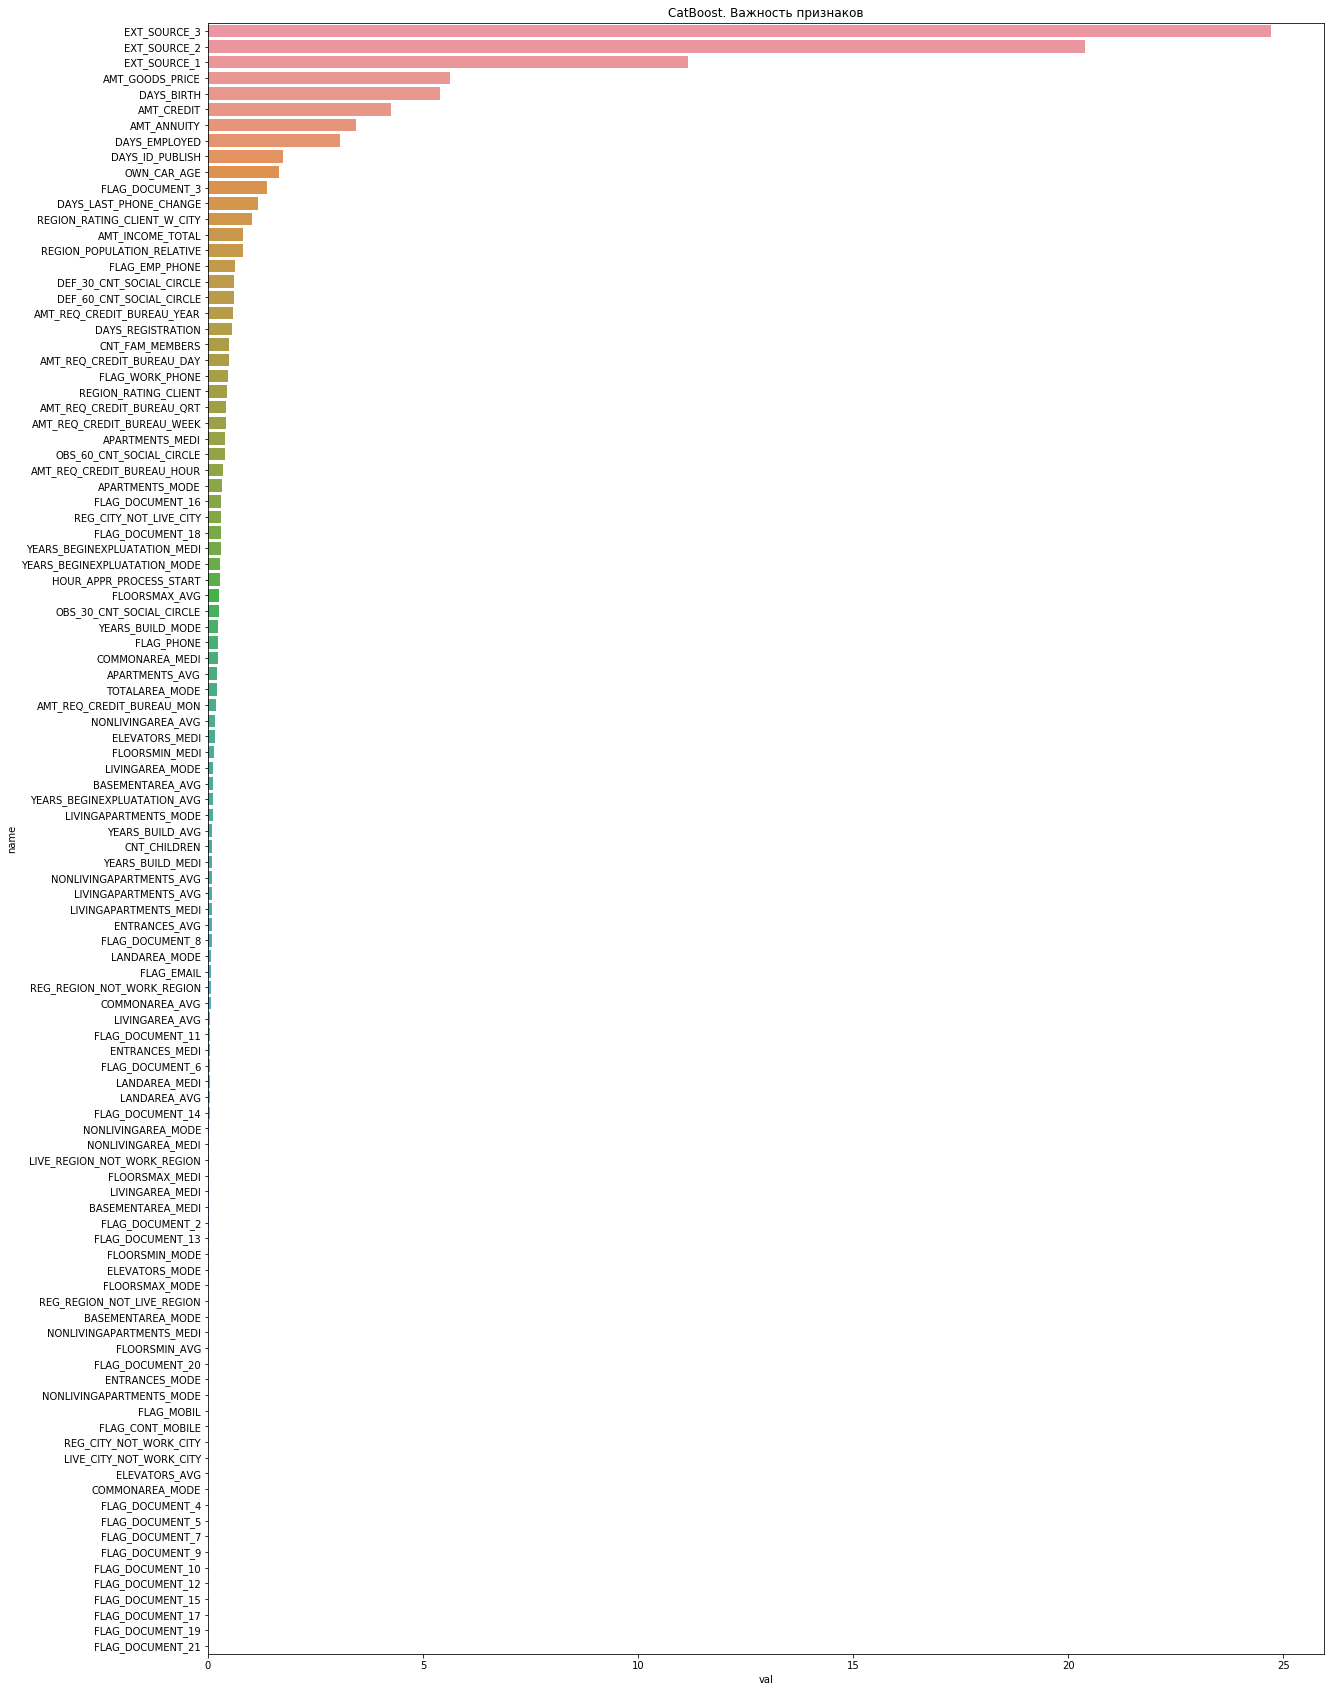

In [169]:
plt.figure(figsize=(20, 30))
sns.barplot(x="val", y="name", data=df)
plt.title('CatBoost. Важность признаков')
plt.show()

In [174]:
x_train, x_test = X_train.copy(), X_test.copy()

In [179]:
x_train.drop(df.name[55:].values, axis=1, inplace=True)
x_test.drop(df.name[55:].values, axis=1, inplace=True)

In [186]:
cats = []
for c in x_train.columns:
    col_type = x_train[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        x_train[c] = x_train[c].astype('category')
        x_test[c] = x_test[c].astype('category')
        cats.append(c)

In [187]:
%%time
cb = CatBoostClassifier(silent=True, learning_rate=0.1, max_depth = 3, n_estimators = 500, cat_features = cats)
cb.fit(x_train, y_train)

CPU times: user 4min 41s, sys: 10.1 s, total: 4min 51s
Wall time: 1min 26s


In [188]:
average_precision_score(y_test, cb.predict_proba(x_test)[:,1])

0.2494868814815127

In [192]:
sorted_feat_lgbm = sorted(zip(lgbm_gs.best_estimator_.feature_importances_, numerical),
                          key = lambda t: t[0], reverse=True)

df2 = pd.DataFrame(sorted_feat_lgbm, columns=['val', 'name'])

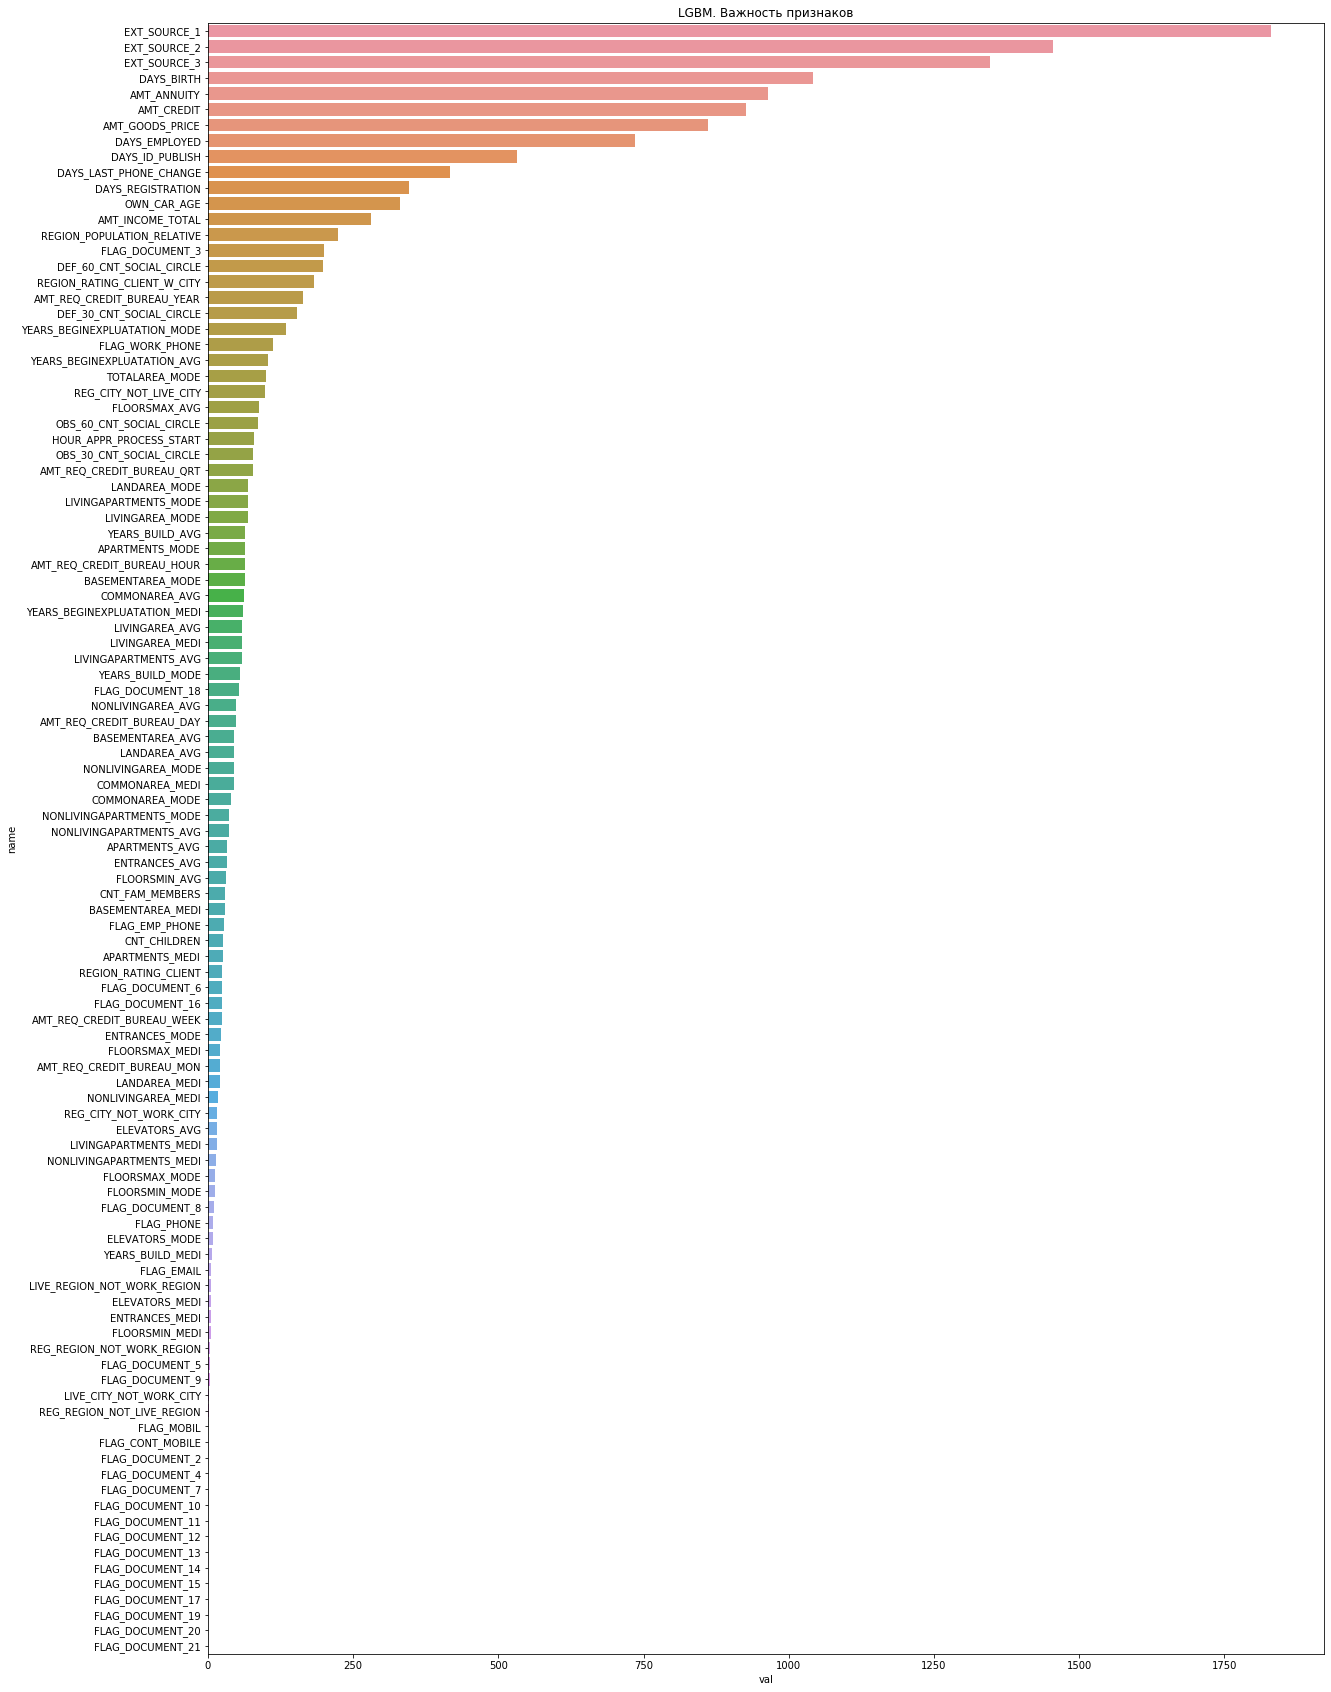

In [193]:
plt.figure(figsize=(20, 30))
sns.barplot(x="val", y="name", data=df2)
plt.title('LGBM. Важность признаков')
plt.show()

In [196]:
x_train, x_test = X_train.copy(), X_test.copy()

x_train.drop(df2.name[65:].values, axis=1, inplace=True)
x_test.drop(df2.name[65:].values, axis=1, inplace=True)

cats = []
for c in x_train.columns:
    col_type = x_train[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        x_train[c] = x_train[c].astype('category')
        x_test[c] = x_test[c].astype('category')
        cats.append(c)

In [197]:
%%time
lgbm = LGBMClassifier(silent=True, learning_rate=0.1, max_depth = 3, n_estimators = 300)
lgbm.fit(x_train, y_train)

CPU times: user 24.2 s, sys: 160 ms, total: 24.4 s
Wall time: 6.63 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=3,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [198]:
average_precision_score(y_test, lgbm.predict_proba(x_test)[:,1])

0.24750379053771848

### Бонус

__Задание 7. (Максимум 5 баллов)__

Градиентный бустинг при всех ограничениях зачастую является ультимативным решением для задач с табличными данными; соревнование от Home Credit не стало исключением. Предлагается любыми модификациями Catboost и LightGBM (другими моделями пользоваться нельзя), обработки данных и построения признаков получить высокое качество на __приватном__ наборе данных. 
Баллы можно получить за следующие значения метрики в inclass-соревновании на Kaggle:
* 0.7955 - 1 балл
* 0.7975 - 3 баллов
* 0.80 - 5 баллов.

При сдаче этого задания необходимо приложить код, с помощью которого можно получить ту же самую метрику, что и в вашем посылке в соревновании. Если решение не будет воспроизводимым, задание засчитано не будет.

Учетная запись на kaggle: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

__Задание 8. (0.5 балла)__ Обратите внимание, что в соревновании метрикой выступает AUC-ROC, у нас же до этого оптимизировался AUC-PR. Можно ли утверждать, что нет необходимости в переобучении моделей для максимизации новой метрики, если мы нашли лучший алгоритм с точки зрения AUC-PR?

In [ ]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ